# download dataset

In [ ]:
! wget https://data.transportation.gov/api/views/8ect-6jqj/rows.csv?accessType=DOWNLOAD

--2020-08-01 15:21:30--  https://data.transportation.gov/api/views/8ect-6jqj/rows.csv?accessType=DOWNLOAD
Resolving data.transportation.gov (data.transportation.gov)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.transportation.gov (data.transportation.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [ <=>                ]   1.43G  2.65MB/s    in 9m 28s  

2020-08-01 15:31:00 (2.57 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1532183381]



In [ ]:
! mv rows.csv?accessType=DOWNLOAD data.csv

# Libraries

In [ ]:
from matplotlib import pyplot as plt
import time
import numpy as np
import datetime
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import math
import os
import os.path
import tensorflow as tf
import time
from datetime import datetime
from pylab import *


# Data Preprocessing

In [ ]:
path='./data.csv'
df=pd.read_csv(path)
df

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,O_Zone,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
0,515,2330,1123,1118848075000,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2,23.31,2.05,3,NaN,NaN,NaN,NaN,NaN,NaN,500,523,119.10,5.11,us-101
1,515,2330,1123,1118848075000,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2,23.31,2.05,3,NaN,NaN,NaN,NaN,NaN,NaN,500,523,119.10,5.11,us-101
2,2224,6548,1902,1113437421700,41.429,472.901,6042814.264,2133542.012,14.3,6.9,2,26.54,-0.76,4,NaN,NaN,NaN,NaN,NaN,NaN,2208,2211,53.34,2.01,i-80
3,2127,6459,567,1118847624800,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2,37.52,11.20,2,NaN,NaN,NaN,NaN,NaN,NaN,2124,2132,48.92,1.30,us-101
4,1033,4827,592,1118848324700,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2,41.99,0.10,1,NaN,NaN,NaN,NaN,NaN,NaN,1029,1040,38.81,0.92,us-101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11850521,1355,5622,938,1113438127100,18.275,1464.336,6042648.149,2134520.896,12.3,6.8,2,1.69,0.17,2,NaN,NaN,NaN,NaN,NaN,NaN,1351,1361,26.91,15.92,i-80
11850522,1474,5688,401,1113438133700,5.509,560.412,6042767.840,2133624.549,17.8,7.9,2,42.94,-4.79,1,NaN,NaN,NaN,NaN,NaN,NaN,1468,1480,74.49,1.73,i-80
11850523,398,2368,654,1113437801700,18.903,635.841,6042771.741,2133701.076,15.2,8.5,2,24.12,-4.21,2,NaN,NaN,NaN,NaN,NaN,NaN,385,406,90.95,3.77,i-80
11850524,599,875,577,1113436854400,77.094,621.358,6042831.282,2133693.854,15.3,6.4,2,13.00,0.00,7,NaN,NaN,NaN,NaN,NaN,NaN,0,611,0.00,0.00,i-80


In [ ]:
df.columns = ['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X', 'Local_Y', 'Global_X', 'Global_Y', 'v_length', 'v_Width', 'v_Class', 'v_Vel', 'v_Acc', 'Lane_ID', 'O_Zone', 'D_Zone', 'Int_ID', 'Section_ID', 'Direction', 'Movement', 'Preceding', 'Following', 'Space_Headway', 'Time_Headway', 'Location']
df.drop(df[df.Location == "i-80"].index, inplace=True)
df.drop(df[df.Location == "lankershim"].index, inplace=True)
df.drop(df[df.Location == "peachtree"].index, inplace=True)
df.drop('D_Zone',axis=1,inplace=True)
df.drop('Space_Headway',axis=1,inplace=True)
df.drop('Time_Headway',axis=1,inplace=True)
df.drop('Following',axis=1,inplace=True)
df.drop('Preceding',axis=1,inplace=True)
df.drop('O_Zone',axis=1,inplace=True)
df.drop('Int_ID',axis=1,inplace=True)
df.drop('Section_ID',axis=1,inplace=True)
df.drop('Direction',axis=1,inplace=True)
df.drop('Movement',axis=1,inplace=True)
df.drop('Location',axis=1,inplace=True)
df.drop('Global_X',axis=1,inplace=True)
df.drop('Global_Y',axis=1,inplace=True)
df["Local_X"] = 0.3048 * df["Local_X"]
df["Local_Y"] = 0.3048 * df["Local_Y"]
df["v_length"] = 0.3048 * df["v_length"]
df["v_Width"] = 0.3048 * df["v_Width"]
df["v_Vel"] = 0.3048 * df["v_Vel"]
df["v_Acc"] = 0.3048 * df["v_Acc"]
df["Vehicle_ID"]=df["Vehicle_ID"]
df['Global_Time']=pd.to_datetime(df['Global_Time'],unit='ms')
df.drop(df[df.v_Class == 1].index, inplace=True)
df.drop(df[df.v_Class == 3].index, inplace=True)
df.drop('v_Width',axis=1,inplace=True)
df.drop('v_length',axis=1,inplace=True)
df.drop('v_Class',axis=1,inplace=True)
df.sort_values(['Vehicle_ID','Total_Frames','Frame_ID','Global_Time'],inplace=True)
df['Global_Time']=df['Global_Time'].dt.strftime('%H:%M:%S:%f')
df

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,v_Vel,v_Acc,Lane_ID
2555981,1,137,421,15:19:30:700000,16.050768,22.529597,7.620000,0.000000,5
7952522,1,138,421,15:19:30:800000,16.047110,23.291597,7.620000,0.000000,5
7911821,1,139,421,15:19:30:900000,16.043148,24.053292,7.620000,0.000000,5
7890998,1,140,421,15:19:31:000000,16.039186,24.815597,7.620000,0.000000,5
7289640,1,141,421,15:19:31:100000,16.035223,25.577597,7.620000,0.000000,5
...,...,...,...,...,...,...,...,...,...
5844029,3109,7188,510,15:01:37:700000,17.500397,640.711546,15.361920,1.508760,5
2894182,3109,7189,510,15:01:37:800000,17.494910,642.250481,15.553944,2.359152,5
430601,3109,7190,510,15:01:37:900000,17.498873,643.778748,15.553944,0.000000,5
2053446,3109,7191,510,15:01:38:000000,17.497654,645.455453,15.553944,0.000000,5


# Plot

In [ ]:
grouped = df.groupby(['Vehicle_ID','Total_Frames'])
########
Vehicles_Trajectoy=[]
for name, group in grouped:
    Vehicles_Trajectoy.append(group)
########
print("number of total trajectories    : ",len(Vehicles_Trajectoy))
lane_keep=[]
lane_change_left=[]
lane_change_right=[]

for path in Vehicles_Trajectoy:
    path.reset_index(inplace=True,drop=True)
    if len(path['Lane_ID'].value_counts())>1:
         for i in path['Lane_ID'].diff()[lambda x: x != 0].index.tolist():
             p=pd.concat([path[i-50:i],path[i:i+50]],ignore_index=True)
             if (p['Local_X'].max()-p['Local_X'].min()>3.5) and (p['Local_Y'].max()-p['Local_Y'].min()<300)and (len(p)==100):
                 trend=[p['Lane_ID'][h] for h in p['Lane_ID'].diff()[lambda x: x != 0].index.tolist()]

                 if (trend[0]<trend[1]) and (len(trend)==2):
                     lane_change_right.append(p)
                 elif (trend[0]>trend[1]) and (len(trend)==2):
                     lane_change_left.append(p)
    elif len(path['Lane_ID'].value_counts())==1:
         chunks = [path[x:x+100] for x in range(0, len(path), 100)]
         for i in chunks:
             if (i['Local_X'].max()-i['Local_X'].min()<1.5) and (len(i)==100):
                 lane_keep.append(i)
                 #print("#############Lane keep number ",len(i))


print("number of lane keep sequence           : ",len(lane_keep))
print("number of lane change left sequence    : ",len(lane_change_left))
print("number of lane change right sequence   : ",len(lane_change_right))
lane_keep=lane_keep[:157]
lane_change_left=lane_change_left[:157]
lane_change_right=lane_change_right[:157]


number of total trajectories    :  5918
number of lane keep sequence           :  34535
number of lane change left sequence    :  303
number of lane change right sequence   :  157


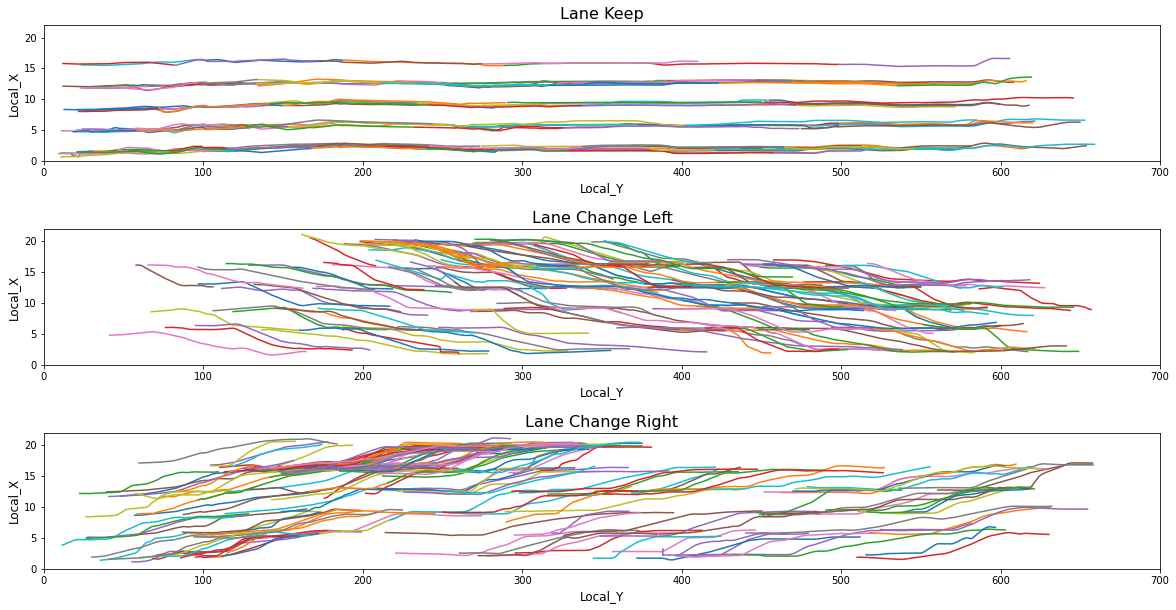

In [ ]:

plt.figure(figsize=(20,10))
subplot(3,1,1)

title('Lane Keep', fontsize=16)
for path in lane_keep:
    path=path.to_numpy()
    yline = path[:,[4]].flatten()
    xline = path[:,[5]].flatten()
    plt.xlim(0, 700)
    plt.ylim(0, 22)
    plt.plot(xline, yline)
    plt.xlabel('Local_Y', fontsize=12)
    plt.ylabel('Local_X', fontsize=12)

subplot(3,1,2)

title('Lane Change Left', fontsize=16)
for path in lane_change_left:
    path=path.to_numpy()
    yline = path[:,[4]].flatten()
    xline = path[:,[5]].flatten()
    plt.xlim(0, 700)
    plt.ylim(0, 22)
    plt.plot(xline, yline)
    plt.xlabel('Local_Y', fontsize=12)
    plt.ylabel('Local_X', fontsize=12)
subplot(3,1,3)

title('Lane Change Right', fontsize=16)
for path in lane_change_right:
    path=path.to_numpy()
    yline = path[:,[4]].flatten()
    xline = path[:,[5]].flatten()
    plt.xlim(0, 700)
    plt.ylim(0, 22)
    plt.plot(xline, yline)
    plt.xlabel('Local_Y', fontsize=12)
    plt.ylabel('Local_X', fontsize=12)



plt.subplots_adjust(hspace=0.5, wspace=1.0)
plt.show()

# Drop some features

In [ ]:

for i in lane_keep:
    i.reset_index(drop=True, inplace=True)
    i=i.drop(['Vehicle_ID','Frame_ID','Total_Frames','Global_Time','Local_Y','Lane_ID'],inplace=True, axis=1)
for i in lane_change_left:
    i.reset_index(drop=True, inplace=True)
    i=i.drop(['Vehicle_ID','Frame_ID','Total_Frames','Global_Time','Local_Y','Lane_ID'],inplace=True, axis=1)
for i in lane_change_right:
    i.reset_index(drop=True, inplace=True)
    i=i.drop(['Vehicle_ID','Frame_ID','Total_Frames','Global_Time','Local_Y','Lane_ID'],inplace=True, axis=1)
print(lane_change_right[1])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      Local_X      v_Vel     v_Acc
0   15.845942  11.433048  0.060960
1   15.809366  11.439144  0.054864
2   15.772790  11.442192 -0.009144
3   15.736519  11.426952 -0.246888
4   15.698419  11.396472 -0.371856
..        ...        ...       ...
95  19.409969  16.349472  1.249680
96  19.418808  16.529304  2.535936
97  19.404787  16.815816  3.246120
98  19.403568  17.160240  3.413760
99  19.401130  17.468088  2.810256

[100 rows x 3 columns]


# Normalization

In [ ]:
Lane_Change_Left_Sampel=[]
Lane_Change_Right_Sampel=[]
Lane_Keep_Sampel=[]

for i in lane_change_left:
    i['Local_X']=(i['Local_X']-i['Local_X'].min())/(i['Local_X'].max()-i['Local_X'].min())
    i['v_Vel']=(i['v_Vel']-i['v_Vel'].min())/(i['v_Vel'].max()-i['v_Vel'].min())
    i['v_Acc']=(i['v_Acc']-i['v_Acc'].min())/(i['v_Acc'].max()-i['v_Acc'].min())
    Lane_Change_Left_Sampel.append(i)

for i in lane_change_right:
    i['Local_X']=(i['Local_X']-i['Local_X'].min())/(i['Local_X'].max()-i['Local_X'].min())
    i['v_Vel']=(i['v_Vel']-i['v_Vel'].min())/(i['v_Vel'].max()-i['v_Vel'].min())
    i['v_Acc']=(i['v_Acc']-i['v_Acc'].min())/(i['v_Acc'].max()-i['v_Acc'].min())
    Lane_Change_Right_Sampel.append(i)

for i in lane_keep:
    i['Local_X']=(i['Local_X']-i['Local_X'].min())/(i['Local_X'].max()-i['Local_X'].min())
    i['v_Vel']=(i['v_Vel']-i['v_Vel'].min())/(i['v_Vel'].max()-i['v_Vel'].min())
    i['v_Acc']=(i['v_Acc']-i['v_Acc'].min())/(i['v_Acc'].max()-i['v_Acc'].min())
    Lane_Keep_Sampel.append(i)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
print(len(Lane_Change_Left_Sampel))
print(len(Lane_Change_Right_Sampel))
print(len(Lane_Keep_Sampel))

157
157
157
